In [25]:
import sys
import cv2 
import os 
import re
import numpy as np
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
import random
print(tf.__version__)



2.1.0


In [3]:
# load data from descriptors
data_dir = "./data"
female_descriptors = np.load(os.path.join(data_dir,"female_descriptors.npy"))
male_descriptors = np.load(os.path.join(data_dir,"male_descriptors.npy"))

In [4]:
# concatenate full dataset and labels
m_len = male_descriptors.shape[0]
f_len = female_descriptors.shape[0]
dataset_descriptors = np.concatenate([male_descriptors,female_descriptors],axis=0)
# males, zero, Women, one
dataset_labels = np.concatenate([np.zeros((m_len,1)),np.ones((f_len,1))],axis=0)
input_shape = dataset_descriptors.shape[1]
print("Dataset input shape: {}".format(dataset_descriptors.shape))
print("Dataset labels shape: {}".format(dataset_labels.shape))

Dataset input shape: (33118, 4096)
Dataset labels shape: (33118, 1)


In [5]:
# apply PCA for visualization purposes
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dataset_descriptors)
print("principal components shape: {}".format(principalComponents.shape))

principal components shape: (33118, 2)


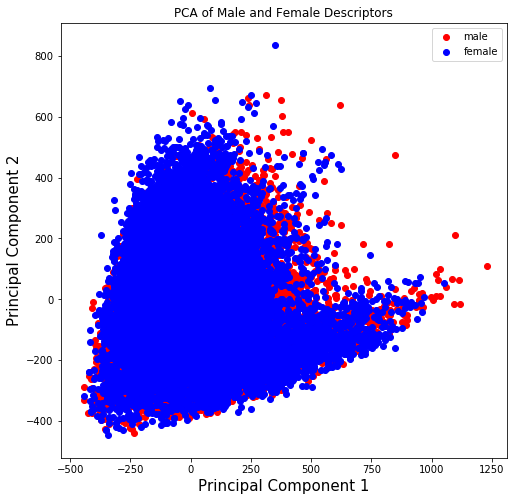

In [6]:
# Visualize 2D PCA 
fig = plt.figure(figsize = (8,8))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
# linear scale factor for visualization of differnces between vectors 
male_principalComponents = principalComponents[:m_len] 
female_principalComponents = principalComponents[m_len:] 
num_samples = -1
plt.scatter(male_principalComponents[:num_samples,0],male_principalComponents[:num_samples,1],c='r')
plt.scatter(female_principalComponents[:num_samples,0],female_principalComponents[:num_samples,1],c='b')
plt.title("PCA of Male and Female Descriptors")
plt.legend(['male','female'])

In [62]:
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices((dataset_descriptors, dataset_labels))
# dataset = tf.data.Dataset.range(10)
dataset = dataset.shuffle(m_len + f_len)
dataset = dataset.batch(batch_size, drop_remainder = False)
dataset_size = len(list(dataset))
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)
# for elem in train_dataset.as_numpy_iterator():
#     print(elem[1])
print("len train dataset: {}".format(len(list(train_dataset))))
print("len val dataset: {}".format(len(list(val_dataset))))
print("len test dataset: {}".format(len(list(test_dataset))))

len train dataset: 1449
len val dataset: 311
len test dataset: 310


In [63]:
# model = keras.Sequential([
#   keras.layers.Dense(1000,input_shape=(input_shape,),activation='relu',name='D0'),
#   keras.layers.Dense(100,activation='relu', name='D1'),
#   keras.layers.Dense(10,activation='relu', name='D2'),
#   keras.layers.Dense(1, activation=tf.nn.softmax, name='sigmoid')
# ])
# model.build()
# model.summary()
class descriptorGenderClassifier(tf.keras.Model):
    def __init__(self):
        super(descriptorGenderClassifier, self).__init__()
        self.dense1 = tf.keras.layers.Dense(1000,input_shape=(None,1), activation=tf.nn.leaky_relu,name='D0')
        self.dense2 = tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu,name='D1')
        self.dense3 = tf.keras.layers.Dense(10, activation=tf.nn.leaky_relu,name='D2')
        self.dense_end = tf.keras.layers.Dense(1, activation='sigmoid',name='DL')
    def call(self, inputs):
#         inp = tf.transpose(inputs)
        inp = inputs
#         print(inp)
        x = self.dense1(inp)
#         print(x)
        x = self.dense2(x)
#         print(x)
        x = self.dense3(x)
#         x = self.dense3(inputs)
        out = self.dense_end(x)
#         print(out)
        return out

model = descriptorGenderClassifier()


In [64]:
epochs = 10
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall','AUC'])
model.trainable = True
model.fit(train_dataset, epochs=epochs,validation_data=val_dataset)

Train for 1449 steps, validate for 311 steps
Epoch 1/10
1449/1449 [==============================] - 19s 13ms/step - loss: 1.2524 - accuracy: 0.9036 - Precision: 0.8989 - Recall: 0.9028 - AUC: 0.9358 - val_loss: 0.2086 - val_accuracy: 0.9306 - val_Precision: 0.8910 - val_Recall: 0.9764 - val_AUC: 0.9847
Epoch 2/10
1138/1449 [======================>.......] - ETA: 3s - loss: 0.3177 - accuracy: 0.9306 - Precision: 0.9279 - Recall: 0.9303 - AUC: 0.9712

KeyboardInterrupt: 

In [100]:
# model.evaluate(test_dataset)
Test_X = []
Test_Y = []
for X,Y in list(test_dataset):
    Test_Y.append(Y.numpy())
    Test_X.append(X.numpy())
Test_X = np.concatenate(Test_X)
Test_Y = np.concatenate(Test_Y)
y_pred = model.predict(Test_X) > 0.5
print(classification_report(Test_Y, y_pred,target_names=['male','female']))

              precision    recall  f1-score   support

        male       0.93      0.98      0.96      2554
      female       0.98      0.93      0.95      2406

   micro avg       0.95      0.95      0.95      4960
   macro avg       0.95      0.95      0.95      4960
weighted avg       0.95      0.95      0.95      4960



In [22]:
# model.save('./vggmodel.pb')

INFO:tensorflow:Assets written to: ./vggmodel.pb/assets


[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
